In [1]:
import os
import glob
import re
import time
import datetime
from string import punctuation
import itertools as it
import numpy as np
from imageio import imwrite
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import random

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.parameter as P
from torch.utils.data import Dataset, DataLoader

import torch.nn.utils.rnn as utils_rnn

torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
np.random.seed(0)

# Sentence sampling

In [4]:
! cat ../data/task3_train.txt | wc -l

23011601


In [5]:
sample_lines = np.random.choice(np.arange(23011601), size=150000, replace=False)

In [6]:
sample_lines = np.sort(sample_lines)

In [6]:
sample_lines.shape

(150000,)

In [7]:
sample_lines[:10]

array([ 157,  181,  343,  609,  618,  655, 1115, 1132, 1151, 1296])

In [8]:
line_no = 0
with open('/home/md359230/DeepLearning/assignment3/data/task3_sample.txt', 'w') as sample_data:
    with open('/home/md359230/DeepLearning/assignment3/data/task3_train.txt', 'r') as full_data:
        for counter, line in enumerate(full_data):
            if line_no < 150000 and counter == sample_lines[line_no]:
                line_no += 1
                max_word_length = max([len(word) for word in line.split()])
                correct_line = True if max_word_length <= 15 else False
                if correct_line:
                    sample_data.write(line)
            

In [9]:
print(line_no)

150000


In [10]:
! cat ../data/task3_sample.txt | wc -l

131723


In [12]:
with open('/home/md359230/DeepLearning/assignment3/data/task3_sample.txt', 'r') as sample_data:
    with open('/home/md359230/DeepLearning/assignment3/data/train.txt', 'w') as train_data:
        with open('/home/md359230/DeepLearning/assignment3/data/validation.txt', 'w') as validation_data:
            for counter, line in enumerate(sample_data):
                if counter < 105378:
                    train_data.write(line)            
                else:
                    validation_data.write(line)


In [13]:
! cat ../data/train.txt | wc -l

105378


In [14]:
! cat ../data/validation.txt | wc -l

26345


# Preprocessing

In [4]:
class CorpusPreprocessor(object):  
    @staticmethod
    def transform_text(text):
        # Remove EOL character
        text = text.replace('\n', ' ')
        
        # Remove numbers
        numbers = '1234567890'
        for number in numbers:
            text = text.replace(number, ' ')
        
        # Remove punctuation
        for specialchar in punctuation:
            text = text.replace(specialchar, ' ')
            
        # Remove double spaces
        double_spaces = re.compile('\s+')
        text = re.sub(double_spaces, ' ', text)
        
        # Trim text
        words = text.split(' ')
        words = [word.lower() for word in words if word]
        text = ' '.join(words)
        
        return text
    
    @staticmethod
    def mask_text(text, corpus_dictionary):
        MASK = 'MASK'
        masked_sent = text.split()
        selected_word_idx = random.randint(0, len(masked_sent) - 1)
        if random.randint(0, 1) == 1:
            original_word = masked_sent[selected_word_idx]
            masked_sent[selected_word_idx] = MASK
            return (masked_sent, original_word, selected_word_idx, 1)
        else:
            random_word = np.random.choice(corpus_dictionary)
            masked_sent[selected_word_idx] = MASK
            return (masked_sent, random_word, selected_word_idx, 0)

In [5]:
CorpusPreprocessor.transform_text('AFDafs  41 2 5$#sa 24 Sfw15 gw g4gfdsaf j.    ')

'afdafs sa sfw gw g gfdsaf j'

In [6]:
CorpusPreprocessor.mask_text(CorpusPreprocessor.transform_text('Ala ma kota.'), ['aaa', 'bbb', 'ccc'])

(['ala', 'MASK', 'kota'], 'aaa', 1, 0)

# Data loading

In [7]:
class NLPDataSet(Dataset):
    def __init__(self, file_path):
        self.sentences = []
        self.corpus_vocab = []
        
        # Load corpus from file
        chars = set()
        with open(file_path, 'r') as raw_data:
            for line in raw_data:
                line = CorpusPreprocessor.transform_text(line)
                chars = chars | set(line)
                self.sentences.append(line)
        
        # Create dict with all letters
        self.chars = OrderedDict(zip(chars, (torch.zeros(len(chars)) for _ in range(len(chars)))))
        for idx, key in enumerate(self.chars.keys()):
            if key != ' ':
                self.chars[key][idx] = 1.
        
        # Fill the dictionary with sample 20%
        for sentence in self.sentences[:len(self.sentences) // 5]:
            for word in sentence.split():
                if len(word) >= 3:
                    self.corpus_vocab.append(word)
    
    def __len__(self):
        return len(self.sentences)
    
    def _encode_word(self, word):
        result = []
        if word == 'MASK':
            return result
        
        for letter in word:
            result.append(self.chars[letter])
    
        return result
    
    def __getitem__(self, idx):
        sentence, word, idx, label = CorpusPreprocessor.mask_text(self.sentences[idx], self.corpus_vocab)
        sentence = [self._encode_word(word) for word in sentence]
        word = self._encode_word(word)
        idx = torch.LongTensor([idx]).view(1)
        label = torch.LongTensor([label]).view(1)
        return sentence, word, idx, label

In [8]:
data_train = NLPDataSet('/home/md359230/DeepLearning/assignment3/data/train.txt')

In [9]:
data_test = NLPDataSet('/home/md359230/DeepLearning/assignment3/data/validation.txt')
data_test.chars = data_train.chars.copy()

In [10]:
data_train.sentences[1]

'jego żołnierza i biedę można znaleźć w repertuarze polskich teatrów'

In [11]:
list(map(len, data_train[1][0]))

[4, 9, 0, 5, 5, 7, 1, 11, 8, 7]

In [12]:
def nlp_collate(batch): 
    def stack_chars(word):
        if len(word) > 1:
            return torch.stack(word)
        else:
            if len(word) == 1:
                return word[0].view(1, -1)
            else:
                return torch.zeros(1, 36)
    
    words = []
    sentences = [] 
    words_length = []
    sentences_length = []
    idxs = []
    labels = [] 
    for sentence, word, idx, label in batch: 
        words.append(word)
        sentences.append(sentence)
        words_length.append(len(word))
        sentences_length.append([len(word) if len(word) > 0 else 1 for word in sentence])
        idxs.append(idx)
        labels.append(label) 
       
    words = [stack_chars(word) for word in words]
    words = utils_rnn.pad_sequence(words)
    sentences = [utils_rnn.pad_sequence(list(map(stack_chars, sentence))) for sentence in sentences]
    words_length = torch.LongTensor(words_length)
    sentences_length = [torch.LongTensor(sentence) for sentence in sentences_length]
    idxs = torch.stack(idxs)
    labels = torch.stack(labels).squeeze(1)
    return sentences, sentences_length, words, words_length, idxs,  labels


In [13]:
dataloader_train = DataLoader(data_train,
                              batch_size=1024,
                              shuffle=True,
                              collate_fn=nlp_collate,
                              num_workers=8)

In [14]:
dataloader_test = DataLoader(data_test,
                             batch_size=1024,
                             shuffle=True,
                             collate_fn=nlp_collate,
                             num_workers=8)

In [15]:
example = next(iter(dataloader_train))

In [16]:
[len(s) for s in example[0]]

[12,
 15,
 13,
 10,
 11,
 10,
 10,
 13,
 13,
 9,
 13,
 10,
 8,
 15,
 13,
 9,
 8,
 14,
 12,
 10,
 15,
 15,
 8,
 10,
 13,
 11,
 10,
 10,
 9,
 13,
 11,
 11,
 12,
 14,
 14,
 11,
 12,
 12,
 15,
 11,
 10,
 12,
 12,
 11,
 9,
 10,
 8,
 12,
 9,
 14,
 12,
 9,
 12,
 14,
 8,
 11,
 10,
 10,
 6,
 13,
 11,
 12,
 15,
 9,
 9,
 12,
 10,
 9,
 14,
 12,
 10,
 13,
 13,
 15,
 14,
 10,
 11,
 9,
 9,
 13,
 14,
 11,
 13,
 12,
 10,
 12,
 14,
 13,
 8,
 13,
 13,
 14,
 13,
 10,
 12,
 15,
 10,
 10,
 12,
 5,
 15,
 11,
 8,
 11,
 11,
 11,
 13,
 10,
 12,
 14,
 13,
 11,
 10,
 9,
 12,
 11,
 9,
 7,
 11,
 13,
 12,
 11,
 11,
 14,
 10,
 10,
 14,
 12]

In [233]:
[s.size() for s in example[0]], [max(e) for e in example[1]]

([torch.Size([13, 10, 36]),
  torch.Size([13, 23, 36]),
  torch.Size([9, 11, 36]),
  torch.Size([9, 12, 36]),
  torch.Size([10, 4, 36]),
  torch.Size([14, 15, 36]),
  torch.Size([12, 15, 36]),
  torch.Size([12, 9, 36]),
  torch.Size([12, 19, 36]),
  torch.Size([12, 12, 36]),
  torch.Size([12, 21, 36]),
  torch.Size([12, 25, 36]),
  torch.Size([9, 14, 36]),
  torch.Size([15, 17, 36]),
  torch.Size([14, 24, 36]),
  torch.Size([9, 9, 36])],
 [tensor(13),
  tensor(13),
  tensor(9),
  tensor(9),
  tensor(10),
  tensor(14),
  tensor(12),
  tensor(12),
  tensor(12),
  tensor(12),
  tensor(12),
  tensor(12),
  tensor(9),
  tensor(15),
  tensor(14),
  tensor(9)])

In [234]:
[e.size() for e in example[1]], example[4]

([torch.Size([10]),
  torch.Size([23]),
  torch.Size([11]),
  torch.Size([12]),
  torch.Size([4]),
  torch.Size([15]),
  torch.Size([15]),
  torch.Size([9]),
  torch.Size([19]),
  torch.Size([12]),
  torch.Size([21]),
  torch.Size([25]),
  torch.Size([14]),
  torch.Size([17]),
  torch.Size([24]),
  torch.Size([9])],
 tensor([[ 1],
         [ 7],
         [ 5],
         [ 0],
         [ 2],
         [13],
         [ 0],
         [ 2],
         [ 8],
         [11],
         [17],
         [15],
         [10],
         [ 9],
         [20],
         [ 2]]))

In [ ]:
%%time
for i, example in enumerate(data_train):
    if i % 1000 == 0:
        print(i)

In [196]:
%%time
for i, batch in enumerate(dataloader_train):
    if i % 1000 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
CPU times: user 16.7 s, sys: 11.6 s, total: 28.4 s
Wall time: 8min 48s


# Network implementation

In [15]:
def linear_layer(in_features, 
                 out_features, 
                 batchnorm_module='default',
                 activation_function='relu', 
                 *args, 
                 **kwargs):
    activation_functions = nn.ModuleDict([
        ['lrelu', nn.LeakyReLU()],
        ['relu', nn.ReLU()],
        ['sigmoid', nn.Sigmoid()]
    ])

    return nn.Sequential(
        nn.Linear(in_features, out_features, *args, **kwargs),
        nn.BatchNorm1d(out_features),
        activation_functions[activation_function]
    )

In [16]:
class LinearStack(nn.Module):
    """Class containing implementation of standard linear stack.
    """
    def __init__(self, sizes, n_classes, *args, **kwargs):
        super(LinearStack, self).__init__()
        self.linear_layers = nn.ModuleList([linear_layer(in_size, out_size, *args, **kwargs)
                                                   for in_size, out_size in zip(sizes, sizes[1:])])
        self.linear_layers.append(nn.Linear(sizes[-1], n_classes))
        
    def forward(self, x):
        """Method implemention linear stack forward pass.
        :param x: Input tensor.
        :return: Processed tensor."""
        for linear_layer in self.linear_layers:
            x = linear_layer(x)
        return x

In [17]:
class WordEmbedder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(WordEmbedder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size)
        
    def forward(self, x): 
        words_input, lengths = x
        words_input = utils_rnn.pack_padded_sequence(input=words_input, 
                                               lengths=lengths, 
                                               enforce_sorted=False)
        out, _ = self.lstm(words_input)
        result, _ = utils_rnn.pad_packed_sequence(out, 
                                            total_length=max(lengths).item())
        idx = (lengths - 1).view(-1, 1)\
                           .expand(len(lengths), 
                                   self.hidden_size)
        idx = idx.unsqueeze(0)
        result = result.gather(0, idx).squeeze(0)
        return result

In [18]:
model = WordEmbedder(36, 100)

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [18]:
example = next(iter(dataloader_train))

In [24]:
example2 = example[2].to(device) 
example3 = example[3].to(device)

In [25]:
out = model((example2, example3))

In [ ]:
out = model((example[2], example[3]))
out.size()

In [242]:
sentences, sentences_length = example[:2]

In [243]:
embeddings = []
for idx in range(len(sentences)):
    embeddings.append(model((sentences[idx], sentences_length[idx])))

[e.size() for e in embeddings]

[torch.Size([15, 100]),
 torch.Size([13, 100]),
 torch.Size([23, 100]),
 torch.Size([22, 100]),
 torch.Size([42, 100]),
 torch.Size([24, 100]),
 torch.Size([12, 100]),
 torch.Size([20, 100]),
 torch.Size([13, 100]),
 torch.Size([8, 100]),
 torch.Size([23, 100]),
 torch.Size([16, 100]),
 torch.Size([8, 100]),
 torch.Size([7, 100]),
 torch.Size([14, 100]),
 torch.Size([11, 100])]

In [19]:
class MainLanguageModel(nn.Module):
    def __init__(self, 
                 input_size,
                 embedding_size,
                 hidden_size, 
                 linear_sizes, 
                 n_classes):
        super(MainLanguageModel, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.wordembedder = WordEmbedder(input_size=input_size, 
                                         hidden_size=embedding_size)
        self.lstm = nn.LSTM(input_size=embedding_size,
                            hidden_size=hidden_size,
                            bidirectional=True)
        self.fc = LinearStack(linear_sizes, 
                              n_classes,     
                              batchnorm_module='default',
                              activation_function='lrelu')
    
    def forward(self, x):
        # Create embeddings
        sentences, sentences_length, words, words_length, idxs = x
        embeddings = []
        
        for idx in range(len(sentences)):
            embeddings.append(self.wordembedder((sentences[idx], sentences_length[idx])))
                
        masked_word_embeddings = self.wordembedder((words, words_length))
        
        # Feed RNN with sentence batch
        lengths = torch.LongTensor([sl.size()[0] for sl in sentences_length])
        sentence_batch = utils_rnn.pad_sequence(embeddings)        
        sentence_batch = utils_rnn.pack_padded_sequence(input=sentence_batch, 
                                                        lengths=lengths, 
                                                        enforce_sorted=False)
        
        out, _ = self.lstm(sentence_batch)
        result, _ = utils_rnn.pad_packed_sequence(out, 
                                                  total_length=max(lengths).item())
        idx = (idxs).view(-1, 1)\
                    .expand(len(lengths), 2 * self.hidden_size)        
        idx = idx.unsqueeze(0)
        result = result.gather(0, idx).squeeze(0)
        
        joined_result = torch.cat((result, masked_word_embeddings), dim=1)
        joined_result = self.fc(joined_result)
            
        # Return embeddings, masked_word_embeddings, sentences_length, idxs
        return joined_result
    

In [27]:
config = {
    'input_size': 36,
    'embedding_size': 100,
    'hidden_size': 50,
    'linear_sizes': (200, 100),
    'n_classes': 2
}

In [28]:
mlm = MainLanguageModel(**config)

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mlm = mlm.to(device)

In [29]:
example = next(iter(dataloader_train))

In [30]:
sentences, sentences_length, words, words_length, idxs, labels = example

In [31]:
sentences = [sentence.to(device) for sentence in sentences]
sentences_length = [sl.to(device) for sl in sentences_length]
words = words.to(device)
words_length = words_length.to(device)
idxs = idxs.to(device)
labels = labels.to(device)

In [32]:
out = mlm((sentences, sentences_length, words, words_length, idxs))
out.size()

torch.Size([1024, 2])

# Network training

In [20]:
class NetTrainer(object):
    def __init__(self, train_loader, test_loader):
        self.trainloader = train_loader
        self.testloader = test_loader
        
    def assess(self, net, test=True, use_gpu=False, device=None):
        correct = 0
        total = 0
        loader = self.testloader if test else self.trainloader
        for data in loader:
            sentences, sentences_length, words, words_length, idxs, labels = data
            if device is not None and (device.__str__() != "cpu") and use_gpu:
                sentences = [sentence.to(device) for sentence in sentences]
                sentences_length = [sl.to(device) for sl in sentences_length]
                words = words.to(device)
                words_length = words_length.to(device)
                idxs = idxs.to(device)
                labels = labels.to(device)
            outputs = net((sentences, sentences_length, words, words_length, idxs))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        dataset_name = 'test' if test else 'train'
        print('Accuracy of the network on {} {} sentences: {:2.4f} %'.format(
            total, dataset_name, 100 * correct / total))         
            
    def train(self, 
              config, 
              n_epoch=5, 
              use_gpu=False, 
              resume_training=False, 
              net_path=None):
        net = MainLanguageModel(**config)
        
        if resume_training:
            net.load_state_dict(torch.load(net_path))          
        
        if use_gpu:
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            if device.__str__() != "cpu":
                net.to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0002, amsgrad=True)

        for epoch in range(n_epoch):
            running_loss = 0.0
            t = time.time()
            net.train()
            
            for i, data in enumerate(self.trainloader, 0):
                sentences, sentences_length, words, words_length, idxs,  labels = data
                
                if use_gpu:
                    if(device.__str__() != "cpu"):
                        sentences = [sentence.to(device) for sentence in sentences]
                        sentences_length = [sl.to(device) for sl in sentences_length]
                        words = words.to(device)
                        words_length = words_length.to(device)
                        idxs = idxs.to(device)
                        labels = labels.to(device)
                    
                optimizer.zero_grad()
                outputs = net((sentences, sentences_length, words, words_length, idxs))
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                if i % 10 == 9:
                    now = datetime.datetime.now()
                    print('[%s , %d, %5d] Loss: %.4f' %
                          (now.strftime('%Y-%m-%d %H:%M:%S'), epoch + 1, i + 1, running_loss / 100))
                    print('[%s , %d, %5d] Elapsed time: %2.4f s' %
                          (now.strftime('%Y-%m-%d %H:%M:%S'), epoch + 1, i + 1, time.time() - t))
                    running_loss = 0.0
                    t = time.time()
            
            net.eval()
            with torch.no_grad():
                if use_gpu:
                    self.assess(net, use_gpu=True, device=device)
                    #self.assess(net, test=False, use_gpu=True, device=device)                
                else:
                    self.assess(net)
                    #self.assess(net, test=False)

        return net


In [21]:
config = {
    'input_size': 36,
    'embedding_size': 200,
    'hidden_size': 100,
    'linear_sizes': (400, 200, 100),
    'n_classes': 2
}

In [22]:
trainer = NetTrainer(dataloader_train, dataloader_test)

In [24]:
model_path = "/home/md359230/DeepLearning/assignment3/src/model.pkl"

In [25]:
model = trainer.train(config, n_epoch=3, use_gpu=True, resume_training=True, net_path=model_path)

[2019-06-03 16:17:28 , 1,    10] Loss: 0.0623
[2019-06-03 16:17:28 , 1,    10] Elapsed time: 89.4656 s
[2019-06-03 16:18:19 , 1,    20] Loss: 0.0622
[2019-06-03 16:18:19 , 1,    20] Elapsed time: 51.6113 s
[2019-06-03 16:19:18 , 1,    30] Loss: 0.0624
[2019-06-03 16:19:18 , 1,    30] Elapsed time: 58.1421 s
[2019-06-03 16:20:15 , 1,    40] Loss: 0.0622
[2019-06-03 16:20:15 , 1,    40] Elapsed time: 57.3205 s
[2019-06-03 16:21:14 , 1,    50] Loss: 0.0619
[2019-06-03 16:21:14 , 1,    50] Elapsed time: 58.7944 s
[2019-06-03 16:22:10 , 1,    60] Loss: 0.0622
[2019-06-03 16:22:10 , 1,    60] Elapsed time: 56.2893 s
[2019-06-03 16:23:06 , 1,    70] Loss: 0.0618
[2019-06-03 16:23:06 , 1,    70] Elapsed time: 56.4797 s
[2019-06-03 16:24:05 , 1,    80] Loss: 0.0615
[2019-06-03 16:24:05 , 1,    80] Elapsed time: 58.1032 s
[2019-06-03 16:25:02 , 1,    90] Loss: 0.0613
[2019-06-03 16:25:02 , 1,    90] Elapsed time: 57.5769 s
[2019-06-03 16:26:02 , 1,   100] Loss: 0.0613
[2019-06-03 16:26:02 , 1,  

### Save checkpoint

In [26]:
model_path = "/home/md359230/DeepLearning/assignment3/src/model.pkl"

In [27]:
torch.save(model.state_dict(), model_path)

### Load checkpoint

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [40]:
model_loaded = MainLanguageModel(**config)
model_loaded.load_state_dict(torch.load(model_path))
model_loaded.eval()
model_loaded.to(device)

MainLanguageModel(
  (wordembedder): WordEmbedder(
    (lstm): LSTM(36, 200)
  )
  (lstm): LSTM(200, 100, bidirectional=True)
  (fc): LinearStack(
    (linear_layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=400, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Linear(in_features=200, out_features=100, bias=True)
        (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (2): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

In [41]:
np.random.seed(0)
random.seed(0)

In [42]:
trainer = NetTrainer(dataloader_train, dataloader_test)
trainer.assess(model_loaded, use_gpu=True, device=device)

Accuracy of the network on 26345 test sentences: 63.1505 %


~63.7616 %

# Network visualzation

# Testing zone

In [7]:
chars = set()
corpus_words = set()
lens = list()
with open('/home/md359230/DeepLearning/assignment3/data/task3_sample.txt', 'r') as sample_data:
    for line in sample_data:
        line = CorpusPreprocessor.transform_text(line)
        lens.append(len(line))
        chars = chars | set(line)
        words = line.split()
        corpus_words = corpus_words | set(words)

(array([7.0255e+04, 2.5162e+04, 3.7240e+03, 6.8500e+02, 1.3800e+02,
        2.6000e+01, 5.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   4.,  137.,  270.,  403.,  536.,  669.,  802.,  935., 1068.,
        1201., 1334.]),
 <a list of 10 Patch objects>)

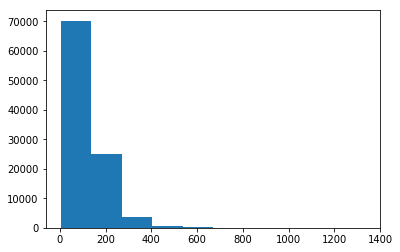

In [37]:
plt.hist(lens)

In [32]:
example = 'Po wybuchu II wojny światowej 1939 podczas kampanii wrześniowej sprawował stanowisko dowódcy 78 pułku piechoty.'
cp.transform_text(example)

'po wybuchu ii wojny światowej podczas kampanii wrześniowej sprawował stanowisko dowódcy pułku piechoty'

In [ ]:
        self.dictionary = OrderedDict()
        self.corpus_path = corpus_path
        with open(corpus_path, 'r') as corpus:
            for line in corpus:
                self.dictionary[]

In [13]:
double_spaces = re.compile('\s+')
re.sub(double_spaces, ' ', 'afs  41 2 5$#sa 24 Sfw15 gw g4gfdsaf j')

'afs 41 2 5$#sa 24 Sfw15 gw g4gfdsaf j'

In [217]:
out.size()

torch.Size([16, 2])

In [180]:
[o.size() for o in out[0]], out[1].size()

([torch.Size([4, 100]),
  torch.Size([6, 100]),
  torch.Size([5, 100]),
  torch.Size([14, 100]),
  torch.Size([9, 100]),
  torch.Size([18, 100]),
  torch.Size([6, 100]),
  torch.Size([22, 100]),
  torch.Size([9, 100]),
  torch.Size([11, 100]),
  torch.Size([6, 100]),
  torch.Size([13, 100]),
  torch.Size([8, 100]),
  torch.Size([6, 100]),
  torch.Size([25, 100]),
  torch.Size([16, 100])],
 torch.Size([16, 100]))

In [181]:
masked_words= out[1]

In [182]:
lengths = torch.LongTensor([o.size()[0] for o in out[2]])

In [191]:
words_input = utils_rnn.pad_sequence(out[0])

words_input.size()

packed_input = utils_rnn.pack_padded_sequence(input=words_input, 
                                             lengths=lengths, 
                                             enforce_sorted=False)

lstm2 = nn.LSTM(input_size=100,
                hidden_size=50,
                bidirectional=True)

out, _ = lstm2(packed_input)
result, _ = utils_rnn.pad_packed_sequence(out, 
                                    total_length=max(lengths).item())
idx = (idxs).view(-1, 1)\
                                     .expand(len(lengths), 
                                             100)
idx = idx.unsqueeze(0)
result_final = result.gather(0, idx).squeeze(0)

result_final.size()

joined_information = torch.cat((result_final, masked_words), dim=1)

fc = LinearStack((200, 100), 2)

final = fc(joined_information)

In [192]:
final.size()

torch.Size([16, 2])

In [193]:
final

tensor([[-0.0788,  0.2965],
        [ 0.3925,  0.1174],
        [ 0.0335, -0.1361],
        [ 0.2581,  0.1808],
        [ 0.1624,  0.1204],
        [ 0.2782,  0.2596],
        [-0.0378,  0.1297],
        [ 0.5840,  0.2376],
        [ 0.2791,  0.1616],
        [ 0.5826,  0.6866],
        [ 0.0406,  0.0681],
        [ 0.5139, -0.0842],
        [-0.0675,  0.0903],
        [ 0.1305,  0.1092],
        [ 0.4054,  0.4469],
        [ 0.0595,  0.0318]], grad_fn=<AddmmBackward>)

In [195]:
loss = nn.CrossEntropyLoss()
loss(final, labels.squeeze(1))

tensor(0.6807, grad_fn=<NllLossBackward>)